# **Analysis of Most Streamed Spotify Songs**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spotify_streaming_df = pd.read_csv('data/spotify_most_streamed_songs.csv')
spotify_streaming_df

FileNotFoundError: [Errno 2] No such file or directory: 'data/spotify_most_streamed_songs.csv'

# **Cleaning the Data**

## **The Dirty Data**

## Visual Inspection of the Data

The cover_url column contains the urls to each song's album art. This largely irrelevant for our purposes, so it's ok to drop.

The in_spotify_charts, in_deezer_charts, in_apple_charts, and in_shazam_charts columns are hard to interpret because it's not clear if higher numbers are better ranks or if lower numbers are better ranks. The Kaggle posting doesn't offer much insight into this situation, so the columns are basically meaningless and we won't use them. Since we're not going to use them, we may as well drop them.

In [ ]:
spotify_streaming_df.drop(columns=['cover_url', 'in_spotify_charts', 'in_apple_charts', 'in_deezer_charts', 'in_shazam_charts'], inplace=True)

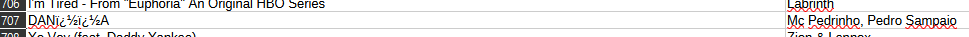

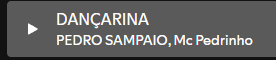

As seen above, some of the track/artist names with asian characters or accent marks are not showing properly likely due to some encoding issue encountered before the data was posted on Kaggle. There's not much we can do about it, but we aren't referencing tracks or artists by name very much, so it won't be an issue.

## Programmatic Inspection of the Data

Now let's check the datatypes of each column for any potential problems.

In [ ]:
spotify_streaming_df.dtypes

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
streams                 object
in_apple_playlists       int64
in_deezer_playlists     object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object

There are two columns whose datatypes need to be corrected as shown in the table below:

| Column | Description |
| ------ | ----------- |
| streams | The number of streams the songs has on spotify |
| in_deezer_playlists | The number of deezer playlists the song is in |

The data in these columns are strings, but would be way more useful as ints.

In [ ]:
# find num NA in each column
print(f'Col{22*" "}Number of NA')
print(40 * '-')
for col in spotify_streaming_df.columns:
  print(f'{col}{(25 - len(col)) * " "}{len(spotify_streaming_df[spotify_streaming_df[col].isna()])}')

print()
print(f'Total number of rows: {len(spotify_streaming_df)}')

Col                      Number of NA
----------------------------------------
track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
streams                  0
in_apple_playlists       0
in_deezer_playlists      0
bpm                      0
key                      95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0

Total number of rows: 953


The only column with missing values is key where the number of missing values is 9.97% of the total data.

There are too many missing values to simply drop those rows.

It might be possible to obtain the missing keys from the Spotify API if we need them later.

In [ ]:
# check for duplicate tracks
num_tracks = len(spotify_streaming_df['track_name'])
num_unique_tracks = len(spotify_streaming_df['track_name'].unique())
dupe_check = "dupes detected" if num_tracks != num_unique_tracks else "no dupes detected"

print(dupe_check)
print(f'# of dupes: {num_tracks - num_unique_tracks}')

dupes detected
# of dupes: 10


It would appear that there are some tracks which share the same name.

In [ ]:
dupes = spotify_streaming_df['track_name'].mode()
dupes

0                           About Damn Time
1                                  Daylight
2                               Die For You
3                                   Flowers
4    Let It Snow! Let It Snow! Let It Snow!
5                                  Miss You
6                                      Numb
7                                      SNAP
8                          SPIT IN MY FACE!
9                            Take My Breath
Name: track_name, dtype: object

The above are the 10 duplicate tracks.

In [ ]:
spotify_streaming_df[spotify_streaming_df['track_name'] == 'About Damn Time']

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
372,About Damn Time,Lizzo,1,2022,7,15,2332,723894473,0,25,109,A#,Minor,84,72,74,10,0,34,7
764,About Damn Time,Lizzo,1,2022,4,14,9021,723894473,242,272,109,A#,Minor,84,72,74,10,0,34,7


In [ ]:
spotify_streaming_df[spotify_streaming_df['track_name'] == 'Take My Breath']

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
512,Take My Breath,The Weeknd,1,2021,8,6,2597,130655803,17,38,121,A#,Minor,70,35,77,1,0,26,4
616,Take My Breath,The Weeknd,1,2021,8,6,6392,432702334,174,344,121,G#,Major,75,53,74,2,0,11,5


It looks like some of the duplicate tracks aren't necessarily duplicates as seen with Take My Breath by The Weeknd as the key, mode, and a few other traits differ.

However, in the case of About Damn Time by Lizzo, it looks like the only thing different between the two tracks is the release date and the metrics related to streams, charts, and playlists.

In order to see how many of the 10 dupes are "true dupes", let's check if they share more than just the track name.

In [ ]:
dupe_traits = [
    'artist(s)_name',
    'artist_count',
    'key',
    'bpm',
    'mode',
    'danceability_%',
    'valence_%',
    'energy_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

true_dupes = 0
for dupe in dupes:
  dupe_data = spotify_streaming_df[spotify_streaming_df['track_name'] == dupe]

  track1 = dupe_data.iloc[0]
  track2 = dupe_data.iloc[1]

  if track1[dupe_traits].eq(track2[dupe_traits]).all():
    print(f'True dupe detected: {track1["track_name"]}')
    true_dupes += 1

print(f'# of true dupes: {true_dupes}')

True dupe detected: About Damn Time
# of true dupes: 1


Looks like About Damn Time by Lizzo is the only real dupe in the dataset. Since it's only 1 track of 953, leaving it in won't cause any serious problems.

In [ ]:
spotify_streaming_df[['released_year', 'released_month', 'released_day']]

,released_year,released_month,released_day
0,2023,7,14
1,2023,3,23
2,2023,6,30
3,2019,8,23
4,2023,5,18
...,...,...,...
948,2022,11,3
949,2022,10,21
950,2022,11,3
951,2022,10,20


The released_year, released_month, and released_day columns are good, but they would be even better as one column containing datetimes.

## **Getting the Grime Off (Actually Cleaning the Data)**

The first order of business is to convert the problematic columns (in_deezer_playlists and streams) from strings to ints.

In [ ]:
spotify_streaming_df['in_deezer_playlists'] = spotify_streaming_df['in_deezer_playlists'].str.replace(',', '').astype(int)

Next is the streams column which represents each song's number of streams on Spotify. The reason it fails to cast normally is due to a particular row having a malformed data point.

In [ ]:
spotify_streaming_df[spotify_streaming_df['streams'].apply(lambda x: not(x.isdigit()))]

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
574,Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,BPM110KeyAModeMajorDanceability53Valence75Ener...,16,54,110,A,Major,53,75,69,7,0,17,3


Since it is a single row of 953 (0.105% of the data), it is fine to remove.

Once it is removed, the conversion is successful.

In [ ]:
spotify_streaming_df.drop(574, inplace=True)
spotify_streaming_df['streams'] = spotify_streaming_df['streams'].astype(int)

Combining the released_year, released_month, and released_day columns into a single release_date column is pretty straightforward.

In [ ]:
col_mapping = {
    'released_year': 'year',
    'released_month': 'month',
    'released_day': 'day'
}

release_dates = pd.to_datetime(spotify_streaming_df.rename(columns=col_mapping)[['year', 'month', 'day']])
spotify_streaming_df.insert(3, 'release_date', release_dates)
spotify_streaming_df.drop(columns=['released_year', 'released_month', 'released_day'], inplace=True)

Now lets see the data after all the cleaning is done.

In [ ]:
spotify_streaming_df

,track_name,artist(s)_name,artist_count,release_date,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023-07-14,553,141381703,43,45,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023-03-23,1474,133716286,48,58,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023-06-30,1397,140003974,94,91,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019-08-23,7858,800840817,116,125,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023-05-18,3133,303236322,84,87,144,A,Minor,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022-11-03,953,91473363,61,37,144,A,Major,60,24,39,57,0,8,3
949,Bigger Than The Whole Sky,Taylor Swift,1,2022-10-21,1180,121871870,4,8,166,F#,Major,42,7,24,83,1,12,6
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022-11-03,573,73513683,2,7,92,C#,Major,80,81,67,4,0,8,6
951,En La De Ella,"Feid, Sech, Jhayco",3,2022-10-20,1320,133895612,29,17,97,C#,Major,82,67,77,8,0,12,5


# **HYPOTHESIS NUMBER 1: Danceability and Energy of Music Composed in Major and Minor Nodes**


**PART 1: Building Our Hypothesis**

A common popular myth in music composition is that music in minor mode tend to be sadder and more moody. We would like to test if there is actually any meaningful correlation between minor modes and the music actually being sadder. This can be done on our data set in the form of looking at how songs in major and minor keys vary in danceability and energy and see if there is a statistically significant difference in these two categories. We can now propose a null and alternative hypothesis for both energy and danceability:

**ENERGY ANALYSIS:**

$H_{0}$ : There is no difference between the distribution of energy level of a song and whether or not it is in a minor mode versus major mode.

$H_{A}$ : There is a meaningful difference between the distribution of energy level of a song and whether or not it is in a minor mode versus major mode.


**DANCEABILITY ANALYSIS:**

$H_{0}$ : There is no difference between the distribution of danceability of a song and whether or not it is in a minor mode versus major mode.

$H_{A}$ : There is a meaningful difference between the distribution of danceability of a song and whether or not it is in a minor mode versus major mode.

We will set the alpha level to be the standard 0.05 and compare our obtained values to this in order to assess statistical significance.

<br>
**Part 2: Data Analysis and Picking our Test to Use**

From our dataset we can see that major and minor modes are two qualitative data points and can be viewed as categorical for when we assess. As for danceability and energy level, both are given as percentages. We can first look at the distribution of both categories overall and then break them into a couple discrete categories to group them by judging by how the distribution of both comes out. We would like to create the following categories for both danceability and energy; High, Medium, Low. The way we will do this is to look at what percentage of the data falls below the 33 percentile and call this Low Energy/Danceability, data between the 33 and 66 percentile as Medium Energy/Danceability and between 66 and 100 percentile as High Energy/Danceability. The code for calculating these is provided below:

In [ ]:
spotify_streaming_df['danceability_%'].describe(percentiles=[.33, .66, 1.0])

count    952.000000
mean      66.984244
std       14.631282
min       23.000000
33%       61.000000
50%       69.000000
66%       75.000000
100%      96.000000
max       96.000000
Name: danceability_%, dtype: float64

In [ ]:
spotify_streaming_df['energy_%'].describe(percentiles=[.33, .66, 1.0])

count    952.000000
mean      64.274160
std       16.558517
min        9.000000
33%       58.000000
50%       66.000000
66%       73.000000
100%      97.000000
max       97.000000
Name: energy_%, dtype: float64

From our calculations above, we can see break down both categories by the following categories and classifications:


**Danceability Breakdown**

| Category | Danceability% In Range |
|---|---|
| Low | 0 - 61 |
| Medium | 61-75 |
| High | 75-96 |

<br>

**Energy Breakdown**



| Category | Energy% In Range |
|---|---|
| Low | 0 - 58 |
| Medium | 58-73 |
| High | 73-97 |
<br>

By making these two values into categorical groups, we now have our independent variable, Major vs Minor Mode, as a categorical value and our dependent variables, Energy % and Danceability % as categorical values as well. Thus the most appropriate statistical test for our data will be **Chi Square Tests** to see if major and minor modes result in different categorical distributions for each dependent variable or not. Now we are ready to break up our data into the aforementioned groups and then analyze the data.

**Part 3: Processing Data and Graphing Outcome**

Lets go ahead and clean up our data so it is groups by major and minor modes and how each break down into the distinct categories:

In [ ]:
hypo_df = spotify_streaming_df.copy()
def categorize_energy(energy):
    if energy <= 58:
        return 'Low'
    elif energy <= 73:
        return 'Medium'
    else: return 'High'

hypo_df['energy_%'] = hypo_df['energy_%'].apply(categorize_energy)
def categorize_energy(danceability):
    if danceability <= 61:
        return 'Low'
    elif danceability <= 75:
        return 'Medium'
    else: return 'High'

hypo_df['danceability_%'] = hypo_df['danceability_%'].apply(categorize_energy)
energy_breakdown = hypo_df[['mode', 'energy_%']].groupby(['mode', 'energy_%']).size().reset_index(name='counts')
energy_breakdown = energy_breakdown.pivot(index='mode', columns='energy_%', values='counts')
energy_breakdown

energy_%,High,Low,Medium
mode,,,
Major,176,200,173
Minor,135,123,145


In [ ]:
danceability_breakdown = hypo_df[['mode', 'danceability_%']].groupby(['mode', 'danceability_%']).size().reset_index(name='counts')
danceability_breakdown = danceability_breakdown.pivot(index='mode', columns='danceability_%', values='counts')
danceability_breakdown

danceability_%,High,Low,Medium
mode,,,
Major,151,219,179
Minor,155,109,139


Now that we have the data broken down into the distinct groups, we can now graph each one to see how the distributions looks. Each graph specifically looks at the distribution of high,medium, and low category songs for major and minor modes. The first graph focuses on mode distributions for energy level and the second is for danceability:

Text(0, 0.5, 'Count')

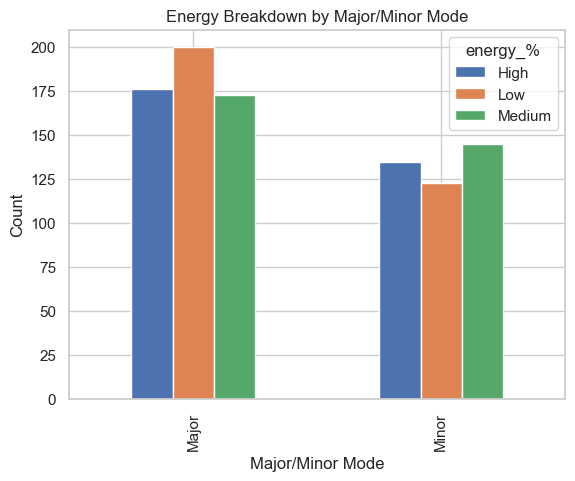

In [ ]:
energy_graph = energy_breakdown.plot(kind='bar')
energy_graph.set_title('Energy Breakdown by Major/Minor Mode')
energy_graph.set_xlabel('Major/Minor Mode')
energy_graph.set_ylabel('Count')

Text(0.5, 0, 'Major/Minor Mode')

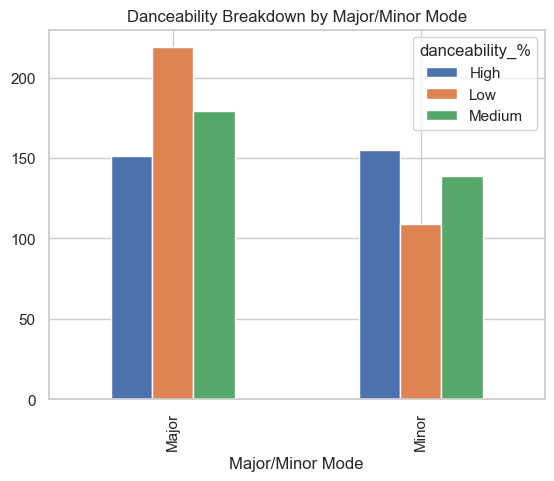

In [ ]:
danceability_breakdown_graph = danceability_breakdown.plot(kind='bar')
danceability_breakdown_graph.set_title('Danceability Breakdown by Major/Minor Mode')
danceability_breakdown_graph.set_xlabel('Major/Minor Mode')

From our graphs above, we can do some quick general analysis and see that the distribution of energy by mode looks relatively similar but the danceability distribution looks significantly different. We can now verify this by doing chi square tests for both energy and danceability. This process first involves creating contingency tables for each and then conducting the chi square test on each:

In [ ]:
from scipy import stats


In [ ]:
contingency_table = pd.crosstab(hypo_df['mode'], hypo_df['danceability_%'])
contingency_table
stats.chi2_contingency(contingency_table)

Chi2ContingencyResult(statistic=np.float64(20.054907162567982), pvalue=np.float64(4.417049254558972e-05), dof=2, expected_freq=array([[176.46428571, 189.1512605 , 183.38445378],
       [129.53571429, 138.8487395 , 134.61554622]]))

In [ ]:
contingency_table_energy = pd.crosstab(hypo_df['mode'], hypo_df['energy_%'])
contingency_table_energy
stats.chi2_contingency(contingency_table_energy)

Chi2ContingencyResult(statistic=np.float64(3.9282250308555486), pvalue=np.float64(0.1402803280146365), dof=2, expected_freq=array([[179.34768908, 186.26785714, 183.38445378],
       [131.65231092, 136.73214286, 134.61554622]]))

**PART 4: Conclusion**

From our Chi Squared tests we can see that our initial observations of the graphs did in fact prove to be correct. The P-Value of the distribution of Major/Minor modes for danceability is 0.00004417 which is far below our set alpha of 0.05 and thus we **REJECT** our null hypothesis and accept our alternate hypothesis that there is a significant difference between major and minor modes and the danceability levels of songs within those modes. In this case it is as we expected and the danceability is lower for minor modes.

On the other hand, the Chi Squared Analysis returned for Major/Minor modes vs Energy distribution gave back a P-Value of 0.14 which is not below our alpha of 0.05 and we **fail** to reject our null hypothesis and conclude that there is no significant difference of energy distribution of songs for major vs minor modes.


## **Hypothesis Number 2: BPM and its Correlation to Popularity**

Looking at the dataframe, I would like to test the beats per minute (bpm) in relation to its popularity:

Since we do not know if the bpm is normally distributed we can check by graphing the bpm


So now lets start with our hypothesis:

* Null Hypothesis: BPM has no effect on the amount of streams of a song

* Alternative Hypothesis: BPM has an effect on the amount of streams of a song


Let us create a visualization for our hypothesis:

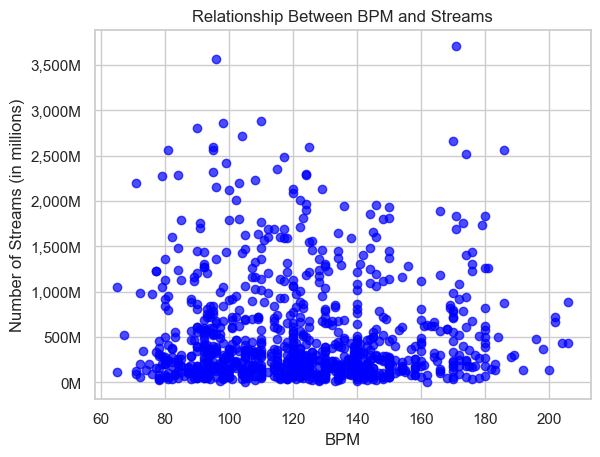

In [ ]:
from matplotlib.ticker import FuncFormatter

plt.scatter(spotify_streaming_df['bpm'],spotify_streaming_df['streams'], color='blue',alpha=.7)

plt.title('Relationship Between BPM and Streams')
plt.xlabel('BPM')
plt.ylabel('Number of Streams (in millions)')

def millions(x, pos):
    return f'{int(x * 1e-6):,}M'

f = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(f)

plt.show()

Now that we have visualized the data, lets conduct a pearson coefficient test for our hypothesis

In [ ]:
import scipy.stats as stats

coefficient,pvalue = stats.pearsonr(spotify_streaming_df['bpm'], spotify_streaming_df['streams'])

print(f'The Pearson coefficient is {coefficient} \n and the pvalue is: {pvalue}')

The Pearson coefficient is -0.0024379081382717837 
 and the pvalue is: 0.9401178701572729


As we can see the pearson value is close to 0, and the pvalue, .95 is greater than .05
So therefore the data is insignificant and we fail to reject the null hypothesis.
The BPM of a song has no effect on the amount of streams it has.

# **Hypothesis Number 3: Valence and the Effect On Streams**

We wish to determine if a track's <i>valence</i> has an effect on its respective number of streams. Valence refers to the musical positiveness or emotional quality of a track. Higher values denote a more cheerful and upbeat sound while lower values denote a more sad and somber sound. Let's assume a confidence level $\alpha$ of 0.05. <br>

Here is our hypotheses:

- $H$<sub>0</sub>: Valence does not affect the number of streams a track receives. <br>

- $H$<sub>A</sub>: Valence has an effect on the number of streams a track receives. <br>

In the dataset, the valence (in percentage) can range from 0 to 100. Let's create a new column that categorizes the track based on three valence groups: low, medium, and high. We can determine the groups by using tertiles, which divides the data into three equal parts, corresponding to the 33rd and 67th percentiles.

- Low Valence: Below 33rd Percentile

- Medium Valence: Between 33rd and 67th Percentile

- High Valence: Above 67th Percentile

We can determine tertiles as follows:

In [ ]:
temp_spotify_stream_df = spotify_streaming_df.copy()
tertiles = temp_spotify_stream_df['valence_%'].quantile([0.33, 0.67])

for t, p in zip(tertiles, ["33rd Percentile", "67th Percentile"]):
    print(f"{p}: {t}")


33rd Percentile: 40.0
67th Percentile: 63.0


Given this we'll define low valence with ranges from 0-40, medium valence with ranges from 41-63, and high valence with ranges 64-100.

Let's now categorize each track into one of the three groups accordingly

In [ ]:
# A function that will be applied to each track and categorize it into the three aforementioned groups accordingly
def categorize_valence(valence):
    if valence <= 40:
        return 'Low'
    elif valence <= 63:
        return 'Medium'
    else: return 'High'

temp_spotify_stream_df['valence_level'] = temp_spotify_stream_df['valence_%'].apply(categorize_valence)


Before we can conduct any statistical or hypothesis testing, we must first determine if the data (i.e. the number of streams) is normally distributed and pick a test accordingly. We can easily accomplish this by creating a histogram for each valence level and visually inspecting if it has a bell-shaped curve.

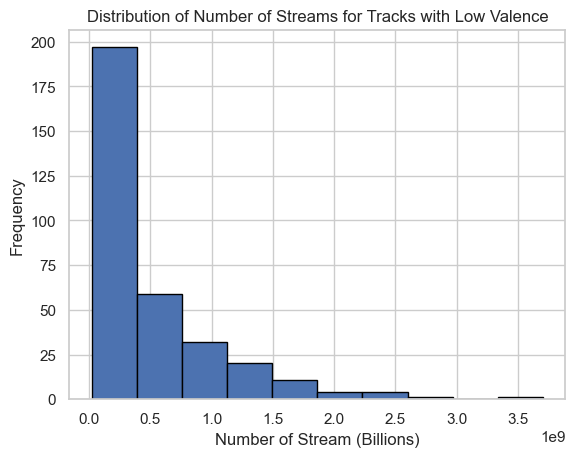

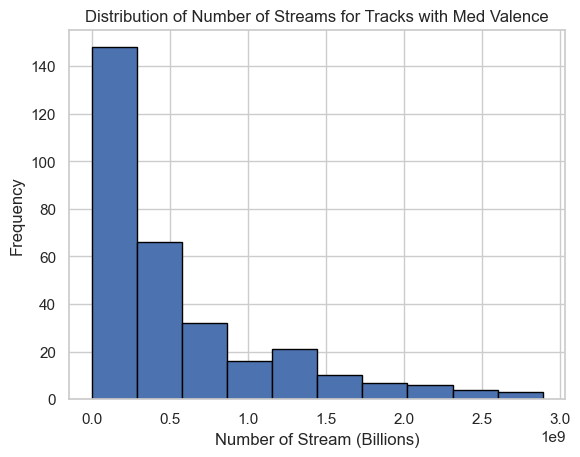

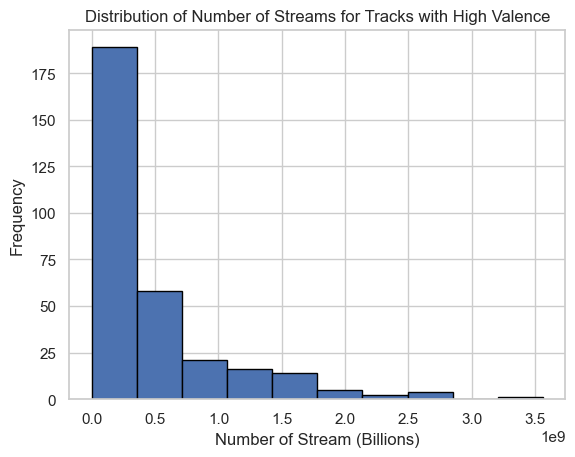

In [ ]:
x = temp_spotify_stream_df.groupby('valence_level')
low = x.get_group('Low')
medium = x.get_group('Medium')
high = x.get_group('High')
groups = [low, medium, high]

for g, valence_level in zip(groups, ['Low', 'Med', 'High']):
    plt.hist(g['streams'], edgecolor= "black")
    plt.xlabel("Number of Stream (Billions)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Number of Streams for Tracks with {valence_level} Valence")
    plt.show()

Observe that the distribution of the number of streams for each valence level does NOT follow a normal distribution. Since normality assumptions are not met, we must use a non-parametric hypothesis test. Furthermore, since we have three samples with a decent amount of outliers, the Mood's median test would be the most appropriate to apply here as it's more robust to outliers compared to Kruskal-Wallis test (although it is generally stronger than the former).

Now let's calculate the p-value:

In [ ]:
import scipy.stats as stats
import numpy as np
p_value = stats.median_test(low['streams'], medium['streams'], high['streams']).pvalue
p_value.item()

0.37315487021822763

Because the P-value (0.333) is significantly higher than $\alpha$ = 0.05, we fail to reject the null hypothesis. This also implies that there is little evidence to suggest that a track's level of valence has an effect on its respective number of streams and that these results are likely to occur under the conditions assumed by the null hypothesis.

Now let's visualize the distribution of data for each valence level:

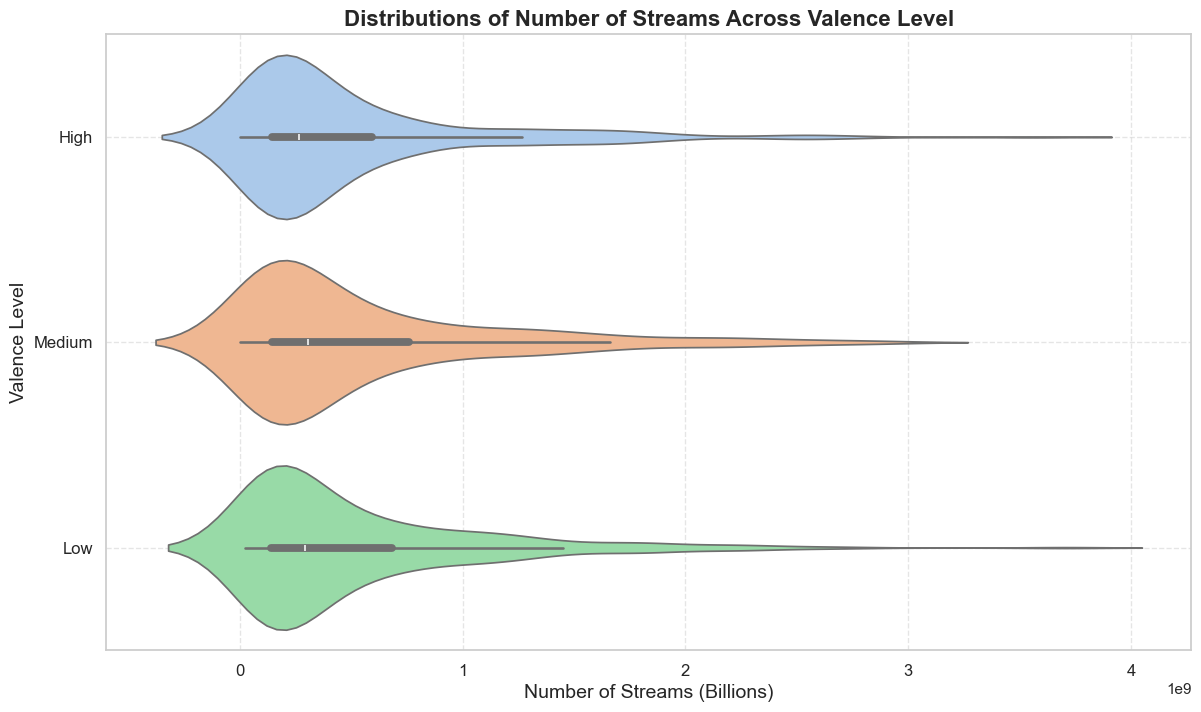

Valence Level,Mean (in Billions),Median (in Billions)
Low,0.507,0.293
Medium,0.554,0.306
High,0.482,0.265


In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 8))
sns.violinplot(y='valence_level', x='streams', hue ="valence_level",data=temp_spotify_stream_df, palette="pastel", legend=False)
plt.xlabel("Number of Streams (Billions)", fontsize=14)
plt.ylabel("Valence Level", fontsize=14)
plt.title("Distributions of Number of Streams Across Valence Level", fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

def rounding(num):
    return f"{round(num/1000000000, 3)}".rstrip("0")

data = {'Valence Level': ['Low', 'Medium', 'High'], 'Mean (in Billions)': [rounding(low['streams'].mean()), rounding(medium['streams'].mean()), rounding(high['streams'].mean())],
        'Median (in Billions)':[rounding(low['streams'].median()), rounding(medium['streams'].median()), rounding(high['streams'].median())]}
statistics = pd.DataFrame(data)
statistics.style.hide(axis="index")

From the violin plot, we can see that there is a relatively similar distribution of the number of streams across each valence level. There are a few differences in the upper and inner quartiles, interquartile ranges (especially between Medium/Low and High valence level), and outliers. However, the most notable similarity is the median and mean number of streams, which ranges from 0.265 to 0.306 and 0.482 to 0.554 billion respectively. The small differences in the distribution implies that there is an inconclusive amount of evidence to suggest that the valence level has an effect on a track's number of streams, aligning with our previous decision to fail to reject the null hypothesis.

# Primary Analysis

For our primary analysis, we would like to circle back to our original question of whether any features of the data are predictive features to the success of a track in regards to its Spotify streams. In our exploratory analysis, we looked at a few features and their effect on streaming such as valence and BPM and found that neither had a meaningful effect on streaming. As such, our working intuition at the moment is that no musical feature will have a very high importance and instead the meta aspects such as number of playlists a track features on will be more important. This analysis required several key design choices which we have highlighted below.

<hr>

**Key Design Decision 1: Choosing Machine Learning Technique**

In order to assess this, we will train a classification model to use on the data. This model will help us determine what features of the data have the most importance in predicting the amount of streams a song gets. In class we learned three machine learning models, classification, regression and clustering. Regression could somewhat help if we wanted to focus on a single feature to test with but our intended approach was more holistic and we didnt see a strong value of clustering the data. So we decided to move forward with a classification model.


<hr>

**Part 1: Laying the groundwork**

We will first import the libraries to be used moving forward.

In [ ]:
# Necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Next we print how many data rows/samples are present as we will refer to this number to help classify the data and choose an appropriate test to training ratio for the data. With near 1000 samples, we have a large database to draw from so we can be more confident of our data be trained accurately.

In [ ]:
print("Number of samples: ", spotify_streaming_df.shape[0])

print("Number of features:", len(spotify_streaming_df.columns))

Number of samples:  952
Number of features: 18


##### ***Part 2: Splitting, Training, and Testing***
Before splitting the data and training, we had a key decision to make in regards to whether we should normalize or standardize any aspect of the data before proceeding. When we cleaned up the data, we got rid of features that were irrelevant such as cover png but there were still some additonal features that were not useful for this section. These were features such as artist name, song title, track mode, artist count. As such we dropped them to not confound the training of the model.
<hr>

**Key Design Decision 2: Feature Engineering**

As we learned in class, feature engineering can use normalization or standardization. Normalization is senstitive to outliers whereas standardization can account for them and work around it. Our intent was to feature engineer the total number of streams in order to make it easier to train the data as opposed to the very large and spread out numbers that our raw data has.

We both standardized and normalized the data seperately to assess which technique was more useful moving forward. We included both the columns below for comparison. As can be seen, for the streamsNormalized column, there is a massive drop off between the top two tracks (Blinding Lights and Shape of Me if the reader is curious) and the rest of the top 10 tracks. The standardized values for these tracks show us that their Z scores are a whopping 5+. As such it is safe to consider these two tracks outliers to the data and thus they could cause issues in the models training. Thus we opted to move forward with **standardized feature engineering** of the streams column.

<hr>

We opted to leave the remaining data as is and not scale them as they are already percentages out of 100 so they can be used directly.

In [ ]:
# Normalize the values between 0 and 1
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

def standardize(series):
  return (series - series.mean()) / (series.std())

# Normalize important columns
spotify_streaming_df['streamsStandardized'] = standardize(spotify_streaming_df['streams'])
spotify_streaming_df['streamsNormalized'] = normalize(spotify_streaming_df['streams'])

#dropping columns
columns_to_drop = ['artist(s)_name', 'release_date', 'artist_count',
                   "mode", "track_name", "key"]
unique_spotify_data = spotify_streaming_df.drop(columns=columns_to_drop)

# Display the DataFrame with ratings
unique_spotify_data = unique_spotify_data.sort_values(by='streamsNormalized', ascending=False)
unique_spotify_data.head(10)

,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,streamsStandardized,streamsNormalized
55,43899,3703895074,672,3421,171,50,38,80,0,0,9,7,5.627095,1.000000
179,32181,3562543890,33,6808,96,83,93,65,58,0,9,8,5.377735,0.961837
86,17836,2887241814,440,1800,110,50,45,41,75,0,11,3,4.186426,0.779515
620,24529,2864791672,533,3595,98,82,54,59,69,0,18,10,4.146821,0.773454
41,24094,2808096550,372,843,90,76,91,50,54,0,7,5,4.046804,0.758147
162,43257,2713922350,433,3631,104,77,36,63,1,0,36,5,3.880670,0.732721
84,17050,2665343922,492,798,170,59,48,76,4,0,10,5,3.794972,0.719605
140,18986,2594040133,250,2969,125,77,74,78,4,0,23,11,3.669184,0.700354
725,28032,2591224264,315,2179,95,75,64,52,41,0,11,3,3.664217,0.699594
48,29536,2565529693,281,2445,186,68,49,59,16,0,13,28,3.618889,0.692657


We first edit the dataframe to set streams to the Standardized values and drop the other columns for clarity.

<hr>

**Key Design Decision 3: Split Ratio and Choosing Y**

We will follow the key machine learning principle of splitting the data and training the machine learning model on the training split before testing it on another part designated as the testing data. This will help prevent overfitting and ensure the model is dynamic and can be applied to new previously unseen data. We are using **80%** of the data  for training and **20%** for testing as we did in most of our class examples. We also picked a seed to use to allow for easy replication by the reader if they choose to run our code.

Our goal is to predict the features of the most successful spotify tracks as compared to other tracks. A Z score of 1.0 means that any sample above it is better than 84.1% of the other data so we set that as the point to train our data around and focus our classifiers on identifying the features most key to songs above this threshhold.

In [ ]:
unique_spotify_data['streams'] = unique_spotify_data['streamsStandardized']
unique_spotify_data.drop(columns=['streamsNormalized', 'streamsStandardized'], inplace=True)

seed = 53
test_size=0.2

#Initialize X and Y
X = unique_spotify_data.drop(columns=['streams'])
y = unique_spotify_data['streams'] > 1.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


Next we normalize both the training and test sets so that the model is trained on features with a consistent scale. If we don't normalize the data, the model may struggle to converge during training because some features could dominate the loss function due to their larger scale. By normalizing the data, we ensure that each feature contributes equally to the learning process, improving the model's ability to find an optimal solution.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### ***Part 3: Choosing a Model and Assessing***

We will train 4 different classifiers: Logistic Regression Model, KNN, DecisionTree, Logistic Regression and Random Forest to see which proves to be the most accurate,both in the technical accuracy rating and in terms of F1 score and precision.

In [ ]:
models = {
          'Logistic Regression': LogisticRegression(random_state=seed),
          'K-Nearest Neighbors': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(random_state=seed),
          'Random Forest': RandomForestClassifier(random_state=seed)
         }

We will perform k-folds cross-validation for each model with a total of 5 k-folds each to offer a robust training of our model. The results are printed below.

In [ ]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

for model_name, model in models.items():
    np.random.seed(seed)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf)
    print(f"{model_name}: Mean = {cv_scores.mean()}, Std Dev = {cv_scores.std()}")

Logistic Regression: Mean = 0.9355951152390782, Std Dev = 0.015841586831184692
K-Nearest Neighbors: Mean = 0.921138630890953, Std Dev = 0.014493065790344737
Decision Tree: Mean = 0.9145682834537323, Std Dev = 0.011122786771754344
Random Forest: Mean = 0.9382266941864466, Std Dev = 0.013594274430046464


For each of the models we also created classification reports in order to evaluate each of them properly beyond simple accuracy:


In [ ]:
for model_name, model in models.items():
    np.random.seed(seed)
    model.fit(X_train_scaled, y_train)

for model_name, model in models.items():
    np.random.seed(seed)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name}: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

Accuracy of Logistic Regression: 0.90
              precision    recall  f1-score   support

       False       0.90      0.99      0.94       158
        True       0.94      0.45      0.61        33

    accuracy                           0.90       191
   macro avg       0.92      0.72      0.78       191
weighted avg       0.90      0.90      0.89       191

Accuracy of K-Nearest Neighbors: 0.92
              precision    recall  f1-score   support

       False       0.91      1.00      0.95       158
        True       1.00      0.55      0.71        33

    accuracy                           0.92       191
   macro avg       0.96      0.77      0.83       191
weighted avg       0.93      0.92      0.91       191

Accuracy of Decision Tree: 0.90
              precision    recall  f1-score   support

       False       0.93      0.95      0.94       158
        True       0.73      0.67      0.70        33

    accuracy                           0.90       191
   macro avg       0

**Key Design Decison 4: Selecting a model**

Now that we have ran the data through each of the models, we must pick which model to assess further. In terms of cross validation accuracy, they all performed relatively well but the clear top two were Logistic Regression and Random Forest. Within these two, random forest both had slightly higher accuracy and a lower standard deviation so it was overall better than logistic regression.


Now looking at the classification report, random forest both had a higher f1 score for false and true compared to logistic regression so our choice was validated by the classification report. Random forest having the highest accuracy of the True rating was very important for us as predicting the higher tracks was the most important aspect to focus on so we felt confident in moving forward with this model. We then extracted the importance features below to conclude the primary analysis.

In [ ]:
# Extract the feature importances from the most accurate model
importances = models['Random Forest'].feature_importances_

# Creating a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns,'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Displaying feature importances
print(feature_importance_df.head(10))

                 Feature  Importance
2    in_deezer_playlists    0.322694
0   in_spotify_playlists    0.304173
1     in_apple_playlists    0.146545
4         danceability_%    0.036969
3                    bpm    0.033556
9             liveness_%    0.031951
10         speechiness_%    0.031496
5              valence_%    0.030690
6               energy_%    0.027108
7         acousticness_%    0.026311


# Visualization

Now that we have successfully trained and evaluated the Random Forest model, it is essential to visualize the feature importance to gain a clearer understanding of which factors played the most significant roles in predicting a song's popularity and to provide valuable insight for musicians on which aspects of their music may influence their chances of success in the streaming landscape. 

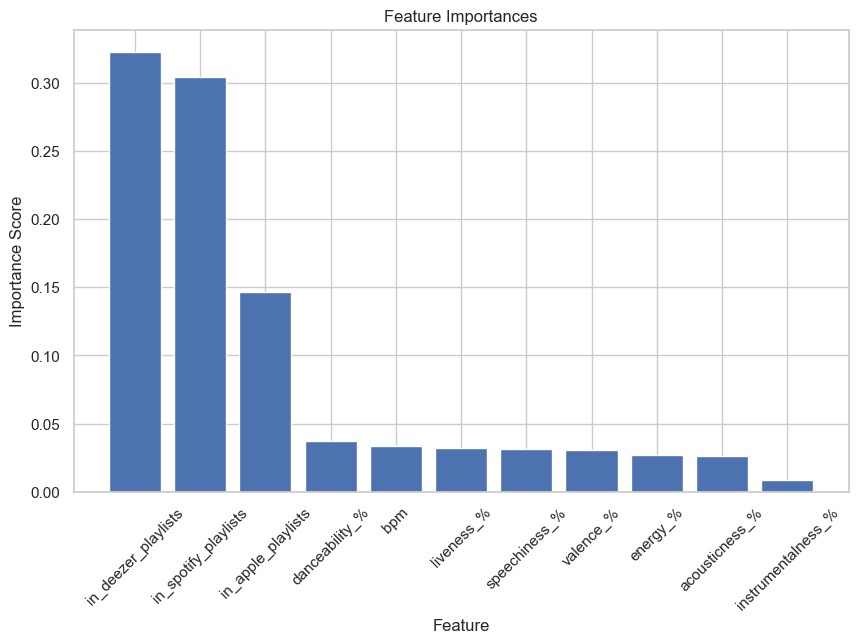

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

Based on these findings, we see that playlist inclusion—specifically on Deezer, Spotify, and Apple Music—emerges as the most significant contributor to predicting a song's popularity. This suggests that the number of playlists the song is featured in plays a crucial role in driving streams and, consequently, a song's overall success. Intuitively, this makes sense, as being included in more playlists can amplify exposure and proliferate streams. However, it's important to recognize that these streaming metrics could also be a <em>consequent</em> or measurement of popularity itself, rather than the cause (correlation is not always causation). In other words, popular songs may be added to playlists due to their existing high streaming numbers, creating a circular dependence that makes it challenging to determine whether playlist inclusion is driving popularity or merely reflecting it.

What's particularly interesting, however, is that musical attributes like danceability, energy, and valence (which are often considered key factors in a song's appeal) don't contribute as significantly to the model's predictions. This aligns with the results of two of our hypothesis tests and suggests that while these features are relevant, they may not be as crucial as the external factor of playlist inclusion when it comes to determining a song's popularity.

**Relationship between Playlist and Musical Features**

Given that our model identifies playlist inclusion as the most significant predictor of a song's popularity, it's worth investigating whether any musical attributes influence a song's likelihood of being included in these playlist. Understanding any potential underlying relationships can provide insight into whether curators prioritize certain musical attributes when selecting songs for playlists. Knowing this could enable musicians or artists to tailor their songs to better align with the preferences of playlist curators, which can ultimately increase the chances of their songs being placed in more playlists and, in turn, boost their popularity. We can use a correlation matrix to determine if any relationship exists between these features. 

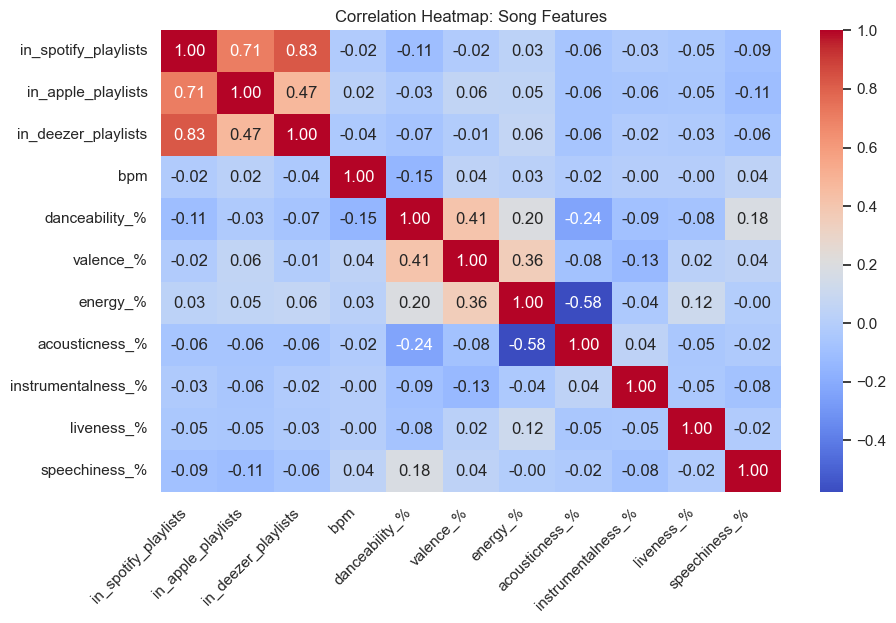

In [ ]:
correlation_matrix = X.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar=True
)
plt.title("Correlation Heatmap: Song Features")
plt.xticks(rotation=45, ha='right')
plt.show()

Nope! The correlation matrix doesn't show a significant relationship between playlist inclusion and musical attributes. However, it does reveal a strong correlation between the number of playlists a song is featured in across different platforms (Deezer, Spotify, and Apple Music), suggesting that songs featured in multiple playlists on one platform are likely to be included in playlists on the other platforms as well.

# Insights and Conclusions

Our data analysis and modeling indicates that the number of playlists a song is featured in across streaming platforms is a significant predictor of its popularity, whereas musical attributes appear to have a lesser impact. However, this is a rather simple conclusion and raises questions about causality: whether playlist inclusion drives popularity or merely reflects it, considering songs with more streams are more likely to be added to playlists. The circularity complicates the interpretation of our results and suggests that further research is needed to establish a clearer relationship.<br>

The inherent nature of our dataset, composed exclusively of top streaming songs on Spotify, introduces a potential bias. By focusing solely on highly popular tracks, we excluded less streamed songs which potentially limited our ability to identify broader trends or patterns related to song popularity. This narrow scope may have prevented us from identifying the features or characteristics that differentiated less popular songs from their highly streamed counterparts. This could explain the little to no correlation between audio features and streams or playlist inclusion. In the future, we should use a more diverse dataset that includes songs and artists with varying levels of streams and popularity in order to extract more meaningful insights into the factors that contribute to a song's popularity. Furthermore, the features in our analysis are limited to those provided by Spotify, which may not capture the full range of factors that contribute to a song's popularity. Factors like regional differences, 

